In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc



### Gaussian Processes

In [95]:
# Define the GP Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)
    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)


def predict_on_new_data(model, likelihood, new_data_path, features, target):
    # Load and preprocess the new data
    feature_tensors, _ = load_and_preprocess_file(new_data_path, features, target)

    # Move the tensors to the same device as the model
    device = next(model.parameters()).device
    feature_tensors = feature_tensors.to(device)

    # Make predictions
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(feature_tensors))
    return observed_pred.mean.cpu().numpy()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [80]:
features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']
folder_path = "/home/beast/An/data/train_new_axis/"

all_filenames = [filename for filename in os.listdir(folder_path) if filename.startswith("diag") and filename.endswith(".h5")]
sorted_filenames = sorted(all_filenames, key=lambda x: int(x[4:-3]))

# Initialize the GP model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

training_iterations = 300

# Iterate over files
for file in sorted_filenames:
    file_path = os.path.join(folder_path, file)
    
    # Load and preprocess the data from the current file
    train_x, train_y = load_and_preprocess_file(file_path, features, target)
    train_y = train_y.squeeze()
    train_x = train_x.to(device)
    train_y = train_y.to(device)

    
    # Define a new GP model using the data from the current file
    model = ExactGPModel(train_x, train_y, likelihood).to(device)
    model.train()
    likelihood.train()
    
    # Initialize the optimizer here, after the model is defined
    optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:  
            print(f'Epoch [{i + 1}/{training_iterations}], File: {file}, Loss: {loss.item()}')


Epoch [200/300], File: diag1.h5, Loss: 0.46509185433387756
Epoch [200/300], File: diag2.h5, Loss: 1.0624449253082275
Epoch [200/300], File: diag3.h5, Loss: 0.9025423526763916
Epoch [200/300], File: diag4.h5, Loss: 0.04309486225247383
Epoch [200/300], File: diag5.h5, Loss: 0.7766801714897156
Epoch [200/300], File: diag6.h5, Loss: 0.6486952900886536
Epoch [200/300], File: diag7.h5, Loss: 0.6006244421005249
Epoch [200/300], File: diag8.h5, Loss: 0.9743479490280151
Epoch [200/300], File: diag9.h5, Loss: 0.2766262888908386
Epoch [200/300], File: diag10.h5, Loss: 0.9816932678222656
Epoch [200/300], File: diag11.h5, Loss: 0.3866584002971649
Epoch [200/300], File: diag12.h5, Loss: 1.0021589994430542
Epoch [200/300], File: diag13.h5, Loss: 0.7163152098655701
Epoch [200/300], File: diag14.h5, Loss: 0.9381450414657593
Epoch [200/300], File: diag15.h5, Loss: 0.7268362641334534
Epoch [200/300], File: diag16.h5, Loss: 0.8550992608070374
Epoch [200/300], File: diag17.h5, Loss: 0.6676015257835388
Epoc

In [81]:
new_data_path = "/home/beast/An/data/train_new_axis/diag10.h5"
predictions = predict_on_new_data(model, likelihood, new_data_path, features, target)

# Append predictions to the original data
test = pd.read_hdf(new_data_path)
test['predicted_odor'] = np.pad(predictions, (0, len(test)-len(predictions)), mode='constant')


Text(0.5, 1.0, '300ep/timeseries')

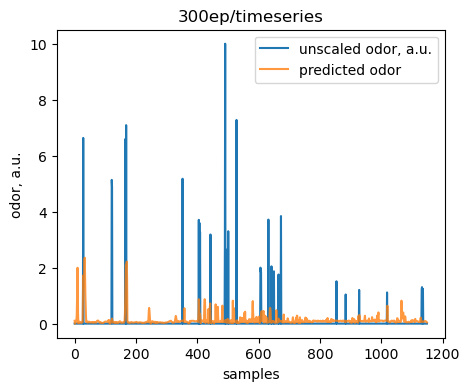

In [82]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(test.odor, label='unscaled odor, a.u.')
ax.plot(test.predicted_odor, alpha=0.8,label='predicted odor')
ax.set_ylabel('odor, a.u.')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('300ep/timeseries')
# mpl_functions.set_fontsize(f, 15)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [60]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>1'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>1'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)


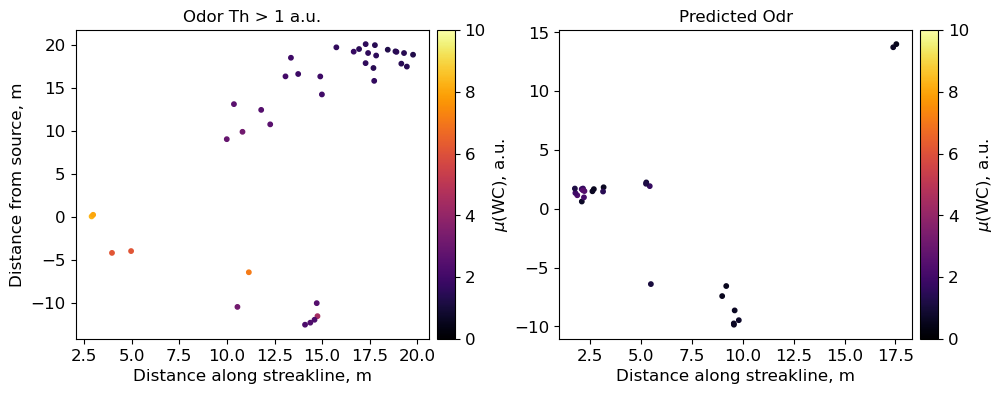

In [62]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

In [57]:
test['scaled_odor']=osc.scale_data(test.odor)

osc.get_time_col(test,0.3)
# osc.calculate_distance_from_source(test)

In [58]:
def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    osc.mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test.odor,0.5)
index_predicted = osc.get_index(test.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

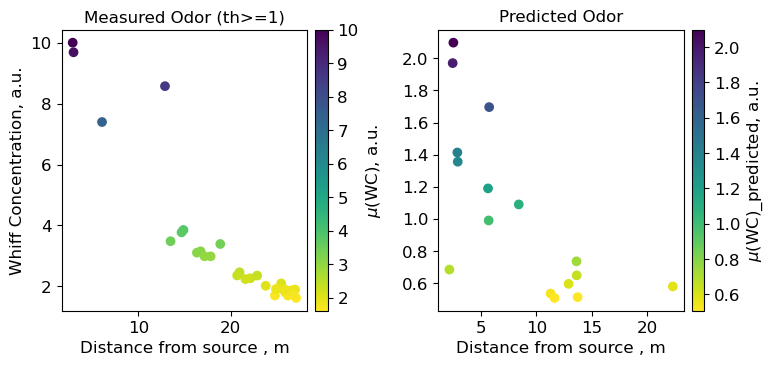

In [59]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('Whiff Concentration, a.u.')
ax1.set_xlabel('Distance from source , m')
ax1.set_title('Measured Odor (th>=1)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

### PINN

In [103]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)
    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)

# 2. Setting up the PINN
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(PINN, self).__init__()
        self.layers = [nn.Linear(input_dim, hidden_layers[0])]
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

# Define the physics-informed loss
def compute_pinn_loss(model, x, true_u, nu=0.01/np.pi):
    u_pred = model(x)
    u_x = torch.autograd.grad(u_pred.sum(), x, create_graph=True)[0][:, 0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0][:, 0]
    
    f = u_x - nu * u_xx
    loss = nn.MSELoss()(u_pred, true_u) + nn.MSELoss()(f, torch.zeros_like(f))
    return loss

# 3. Training the PINN
def train_pinn(model, data, epochs=1000, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    x_train, u_train = data

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_pinn_loss(model, x_train, u_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


def predict_on_new_data(pinn_model, data_path, features, target, seq_length, device):
    # Load and preprocess the new data
    feature_tensors, _ = load_and_preprocess_file(data_path, features, target)

    # Create sequences and flatten them
    sequences, _ = create_sequences(feature_tensors, _, seq_length)
    sequences = sequences.view(-1, seq_length * len(features))

    # Move the sequences to the specified device
    sequences = sequences.to(device)

    # Make predictions using the model
    pinn_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = pinn_model(sequences)
    
    # Convert the predictions to a numpy array
    return predictions.cpu().numpy()



In [101]:
features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']
seq_length = 5

# Define your PINN model
input_dim = seq_length * len(features)  # Input dimensionality is sequence length times number of features
hidden_layers = [128, 128, 128]
output_dim = 1
pinn_model = PINN(input_dim, hidden_layers, output_dim).to(device)

# Directory path
filepath = "/home/beast/An/data/train_new_axis/"

# Loop over all files in the directory
for file in os.listdir(filepath):
    # Load and preprocess data
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    # Flatten sequences for PINN input
    sequences = sequences.view(-1, seq_length * len(features)).to(device)
    targets = targets.to(device)

    # Train the PINN on this file's data
    train_pinn(pinn_model, (sequences, targets), epochs=200)


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1395, 1, 1])) that is different to the input size (torch.Size([1395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.22726038098335266
Epoch 100, Loss: 0.22704370319843292


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([995, 1, 1])) that is different to the input size (torch.Size([995, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.19779856503009796
Epoch 100, Loss: 0.19778724014759064


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1045, 1, 1])) that is different to the input size (torch.Size([1045, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.6622601747512817
Epoch 100, Loss: 0.659583568572998


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1345, 1, 1])) that is different to the input size (torch.Size([1345, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.4421670436859131
Epoch 100, Loss: 0.4418855309486389


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1745, 1, 1])) that is different to the input size (torch.Size([1745, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.3106745779514313
Epoch 100, Loss: 0.3093435764312744


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1395, 1, 1])) that is different to the input size (torch.Size([1395, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.215179443359375
Epoch 100, Loss: 0.21514488756656647


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1545, 1, 1])) that is different to the input size (torch.Size([1545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.2219039350748062
Epoch 100, Loss: 0.22171306610107422


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1595, 1, 1])) that is different to the input size (torch.Size([1595, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.39346346259117126
Epoch 100, Loss: 0.39177584648132324


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1145, 1, 1])) that is different to the input size (torch.Size([1145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.4295603632926941
Epoch 100, Loss: 0.42955195903778076


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([945, 1, 1])) that is different to the input size (torch.Size([945, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.44058728218078613
Epoch 100, Loss: 0.44057199358940125


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([895, 1, 1])) that is different to the input size (torch.Size([895, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.40915894508361816
Epoch 100, Loss: 0.4091077148914337


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1595, 1, 1])) that is different to the input size (torch.Size([1595, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.23633332550525665
Epoch 100, Loss: 0.23535597324371338


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1595, 1, 1])) that is different to the input size (torch.Size([1595, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.38387539982795715
Epoch 100, Loss: 0.3835563659667969


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1445, 1, 1])) that is different to the input size (torch.Size([1445, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.2026616930961609
Epoch 100, Loss: 0.20184960961341858


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1545, 1, 1])) that is different to the input size (torch.Size([1545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.25805163383483887
Epoch 100, Loss: 0.2578383684158325


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1295, 1, 1])) that is different to the input size (torch.Size([1295, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.5958639979362488
Epoch 100, Loss: 0.5935387015342712


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1545, 1, 1])) that is different to the input size (torch.Size([1545, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.22366714477539062
Epoch 100, Loss: 0.22080746293067932


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1745, 1, 1])) that is different to the input size (torch.Size([1745, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1355820596218109
Epoch 100, Loss: 0.13530631363391876


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([895, 1, 1])) that is different to the input size (torch.Size([895, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.029117044061422348
Epoch 100, Loss: 0.02862958423793316


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([945, 1, 1])) that is different to the input size (torch.Size([945, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1585872918367386
Epoch 100, Loss: 0.15838879346847534


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([945, 1, 1])) that is different to the input size (torch.Size([945, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.5160913467407227
Epoch 100, Loss: 0.5137911438941956


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1145, 1, 1])) that is different to the input size (torch.Size([1145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.10378563404083252
Epoch 100, Loss: 0.10212655365467072


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1495, 1, 1])) that is different to the input size (torch.Size([1495, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.27908849716186523
Epoch 100, Loss: 0.2785446047782898


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1145, 1, 1])) that is different to the input size (torch.Size([1145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.20532923936843872
Epoch 100, Loss: 0.20523902773857117


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1845, 1, 1])) that is different to the input size (torch.Size([1845, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.33762040734291077
Epoch 100, Loss: 0.3376108705997467


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1845, 1, 1])) that is different to the input size (torch.Size([1845, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1408960074186325
Epoch 100, Loss: 0.13896514475345612


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([995, 1, 1])) that is different to the input size (torch.Size([995, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.4753482937812805
Epoch 100, Loss: 0.4729776978492737


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1745, 1, 1])) that is different to the input size (torch.Size([1745, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.21726372838020325
Epoch 100, Loss: 0.21597830951213837


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1095, 1, 1])) that is different to the input size (torch.Size([1095, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.2125830352306366
Epoch 100, Loss: 0.2125759720802307


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([995, 1, 1])) that is different to the input size (torch.Size([995, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.20582352578639984
Epoch 100, Loss: 0.20562516152858734


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1295, 1, 1])) that is different to the input size (torch.Size([1295, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.24726828932762146
Epoch 100, Loss: 0.2467583566904068


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1245, 1, 1])) that is different to the input size (torch.Size([1245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.33782169222831726
Epoch 100, Loss: 0.3365512490272522


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.5884122252464294
Epoch 100, Loss: 0.5875661373138428


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1095, 1, 1])) that is different to the input size (torch.Size([1095, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.17329807579517365
Epoch 100, Loss: 0.16990770399570465


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([945, 1, 1])) that is different to the input size (torch.Size([945, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.3843916952610016
Epoch 100, Loss: 0.3833634853363037


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1145, 1, 1])) that is different to the input size (torch.Size([1145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.19593104720115662
Epoch 100, Loss: 0.19555288553237915


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1045, 1, 1])) that is different to the input size (torch.Size([1045, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.12817275524139404
Epoch 100, Loss: 0.1274678260087967


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1495, 1, 1])) that is different to the input size (torch.Size([1495, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.2491130381822586
Epoch 100, Loss: 0.24802552163600922


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1595, 1, 1])) that is different to the input size (torch.Size([1595, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.06589946150779724
Epoch 100, Loss: 0.06395228952169418


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.21656575798988342
Epoch 100, Loss: 0.21519936621189117


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.11996608972549438
Epoch 100, Loss: 0.11949111521244049


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1845, 1, 1])) that is different to the input size (torch.Size([1845, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.14877541363239288
Epoch 100, Loss: 0.1487753987312317


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.41412442922592163
Epoch 100, Loss: 0.412038117647171


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1131565198302269
Epoch 100, Loss: 0.11117527633905411


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([895, 1, 1])) that is different to the input size (torch.Size([895, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.16109366714954376
Epoch 100, Loss: 0.16071096062660217


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1445, 1, 1])) that is different to the input size (torch.Size([1445, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.15307199954986572
Epoch 100, Loss: 0.15291981399059296


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1245, 1, 1])) that is different to the input size (torch.Size([1245, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.36155781149864197
Epoch 100, Loss: 0.36062344908714294


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1795, 1, 1])) that is different to the input size (torch.Size([1795, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1915857195854187
Epoch 100, Loss: 0.1913071870803833


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1445, 1, 1])) that is different to the input size (torch.Size([1445, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.3836662769317627
Epoch 100, Loss: 0.3834448754787445


/home/beast/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1145, 1, 1])) that is different to the input size (torch.Size([1145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.2947481870651245
Epoch 100, Loss: 0.2946200370788574


In [105]:
# Now, use the function to predict on new data:
new_data_path = "/home/beast/An/data/train_new_axis/diag40.h5"
predictions = predict_on_new_data(pinn_model, new_data_path, features, target, seq_length, device)
# Append predictions to the original dataframe
test = pd.read_hdf(new_data_path)
test['predicted_odor'] = np.pad(predictions.flatten(), (0, len(test) - len(predictions)), mode='constant')


Text(0.5, 1.0, '300ep/timeseries')

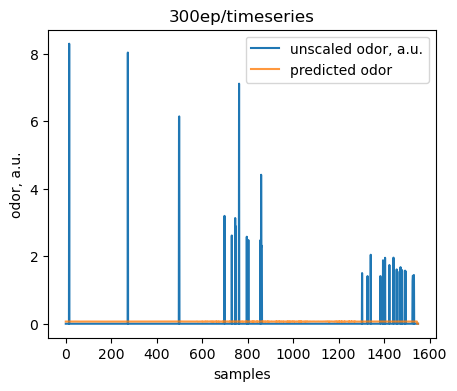

In [106]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(test.odor, label='unscaled odor, a.u.')
ax.plot(test.predicted_odor, alpha=0.8,label='predicted odor')
ax.set_ylabel('odor, a.u.')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('300ep/timeseries')
# mpl_functions.set_fontsize(f, 15)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")